In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_path=HOUSING_PATH,housing_url=HOUSING_URL):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

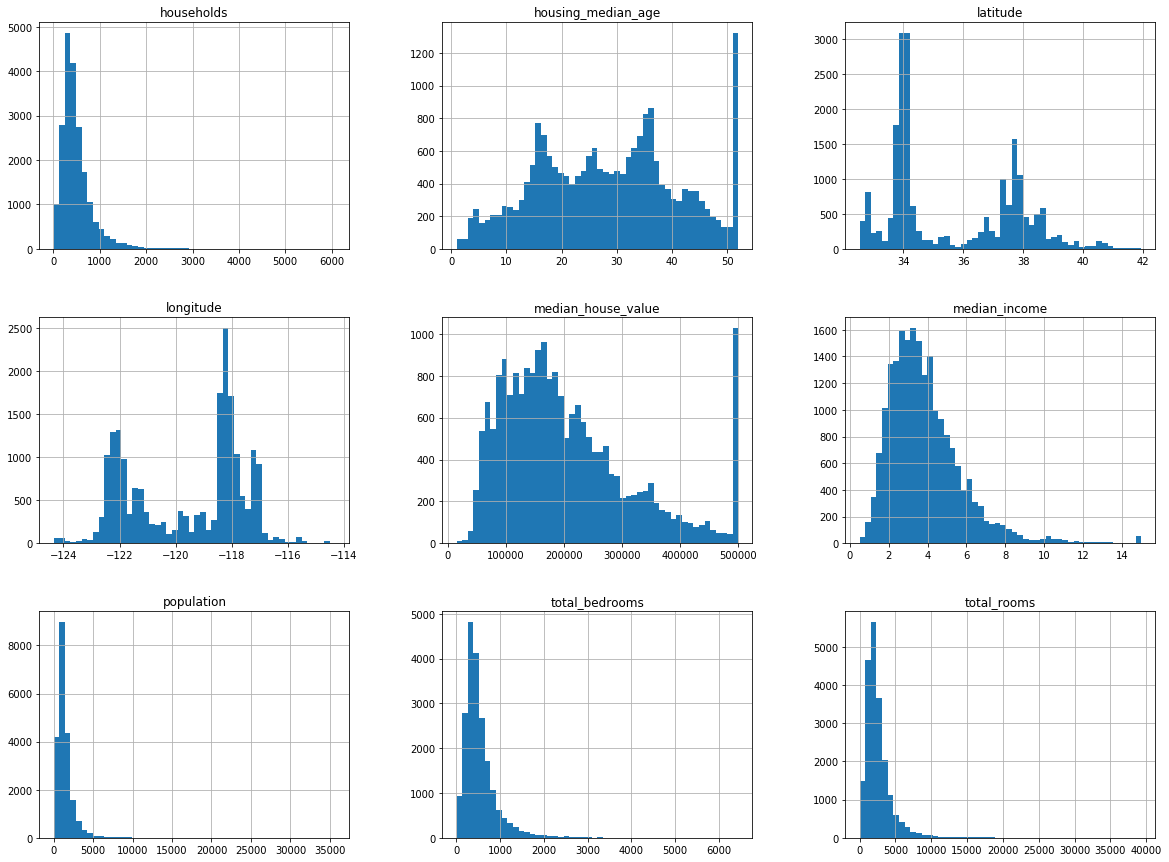

In [7]:
%matplotlib inline
housing.hist(bins=50,figsize=(20,15))
plt.show()

In [8]:
def split_train_data(data,test_ratio):
    shuffled_index = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    train_indices = shuffled_index[test_set_size:]
    test_indices = shuffled_index[:test_set_size]
    return data.iloc[train_indices], data.iloc[test_indices]
train_data, test_data = split_train_data(housing,0.3)
len(train_data),len(test_data)

(14448, 6192)

In [9]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_data_by_id(data,test_ratio,id_coulmn):
    ids = data[id_coulmn]
#     print(ids)
    in_test_set = ids.apply(lambda id_:test_set_check(id_,test_ratio))
#     print(in_test_set)
    return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_data_by_id(housing_with_id,0.3,"index")
len(train_set),len(test_set)

(14449, 6191)

In [11]:
housing_with_id["id"] = housing["longitude"]*1000+housing["latitude"]
train_set,test_set = split_train_data_by_id(housing_with_id,0.3,"id")
len(train_set),len(test_set)

(14386, 6254)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_set, test_set = train_test_split(housing,random_state=42,test_size=0.3)
len(train_set),len(test_set)

(14448, 6192)

In [14]:
#sampling at random from a large dataset is ok. but if the dataset is small then there is the risk of sampling bias
#we consider stratified sampling to maintain the ratio while sampling

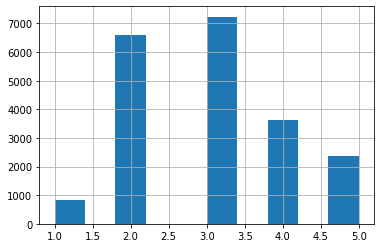

In [15]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0,1.5,3,4.5,6,np.inf],
                              labels=[1,2,3,4,5])
housing["income_cat"].hist()

In [37]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=42)
for train_index, test_index in split.split(housing,housing["income_cat"]):
    strat_test_set = housing.loc[test_index]
    strat_train_set = housing.loc[train_index]

In [38]:
strat_test_set["median_income"].value_counts()/len(strat_test_set)

2.1250    0.003391
4.1250    0.003391
4.0000    0.002907
3.8750    0.002422
4.6250    0.002422
            ...   
3.8816    0.000484
3.7857    0.000484
3.4886    0.000484
5.0417    0.000484
4.8583    0.000484
Name: median_income, Length: 1841, dtype: float64

In [39]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)

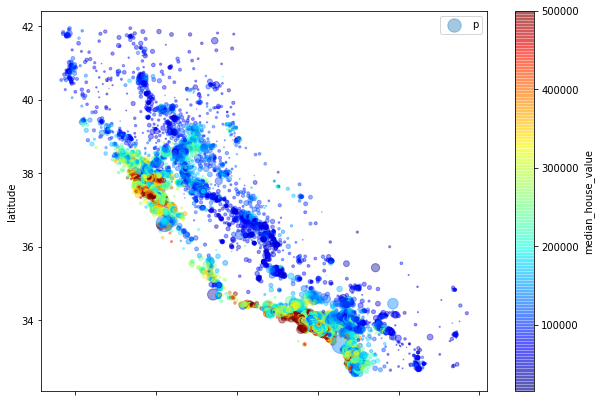

In [40]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,s=housing["population"]/100,
             c="median_house_value",figsize=(10,7),colorbar=True,cmap=plt.get_cmap('jet'))
plt.legend("population")

In [43]:
corr_matrix = housing.corr()

In [54]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7778ad7e10>,
      dtype=object)

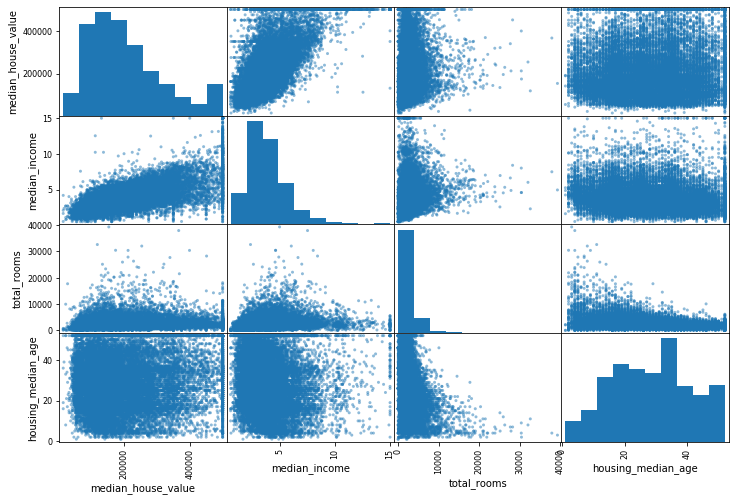

In [55]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

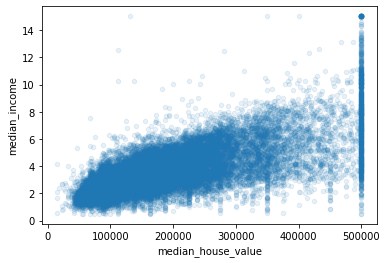

In [56]:
housing.plot(kind="scatter",x="median_house_value",y="median_income",alpha=0.1)

In [60]:
housing["room_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedroom_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [63]:
housing.corr()["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
room_per_household          0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedroom_per_room           -0.255880
Name: median_house_value, dtype: float64

In [65]:
housing.shape

(20640, 14)

In [71]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_test = housing.copy()
housing_labels = strat_train_set["median_house_value"].copy()
housing.shape

(18576, 9)

In [72]:
housing_test.shape

(18576, 9)

In [91]:
#removing corresponding data
housing_test.dropna(subset=["total_bedrooms"])
#droping the whole attribute
housing_test.drop("total_bedrooms",axis=1)
#filling values
median = housing["total_bedrooms"].median()
housing.fillna(median,inplace=True)

In [83]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [87]:
housing_num = housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [89]:
imputer.statistics_

array([-118.5   ,   34.26  ,   29.    , 2124.    ,  433.    , 1164.    ,
        408.5   ,    3.5332])

In [98]:
housing_num.median().values

array([-118.5   ,   34.26  ,   29.    , 2124.    ,  433.    , 1164.    ,
        408.5   ,    3.5332])

In [99]:
X = imputer.transform(housing_num)

In [207]:
pd.DataFrame(X,columns=housing_num.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-118.26,34.06,33.0,1950.0,1047.0,3707.0,1012.0,1.7238
1,-120.72,38.38,9.0,1787.0,347.0,806.0,306.0,2.5250
2,-118.37,34.08,52.0,2946.0,695.0,1258.0,650.0,3.9783
3,-118.31,34.02,46.0,2217.0,489.0,1227.0,448.0,1.6851
4,-120.23,39.56,14.0,1781.0,346.0,734.0,287.0,2.4600
...,...,...,...,...,...,...,...,...
18571,-118.21,33.88,38.0,929.0,166.0,686.0,183.0,3.4485
18572,-119.46,35.17,40.0,4164.0,812.0,1998.0,773.0,2.8323
18573,-118.28,34.24,32.0,2542.0,526.0,1278.0,493.0,4.4500
18574,-117.96,34.03,35.0,1623.0,331.0,1462.0,312.0,3.9803


In [106]:
pd.DataFrame(imputer.fit_transform(housing_num),columns=housing_num.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-118.26,34.06,33.0,1950.0,1047.0,3707.0,1012.0,1.7238
1,-120.72,38.38,9.0,1787.0,347.0,806.0,306.0,2.5250
2,-118.37,34.08,52.0,2946.0,695.0,1258.0,650.0,3.9783
3,-118.31,34.02,46.0,2217.0,489.0,1227.0,448.0,1.6851
4,-120.23,39.56,14.0,1781.0,346.0,734.0,287.0,2.4600
...,...,...,...,...,...,...,...,...
18571,-118.21,33.88,38.0,929.0,166.0,686.0,183.0,3.4485
18572,-119.46,35.17,40.0,4164.0,812.0,1998.0,773.0,2.8323
18573,-118.28,34.24,32.0,2542.0,526.0,1278.0,493.0,4.4500
18574,-117.96,34.03,35.0,1623.0,331.0,1462.0,312.0,3.9803


In [111]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
4586,<1H OCEAN
1046,INLAND
4358,<1H OCEAN
4954,<1H OCEAN
18816,INLAND


In [113]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [128]:
ordinal_encoder.fit_transform(housing_cat)[:10]


array([[0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [4.],
       [0.],
       [1.]])

In [133]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [138]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [139]:
from sklearn.base import BaseEstimator, TransformerMixin

In [140]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

In [161]:
class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X , y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:,rooms_ix]/X[:,households_ix]
        population_per_household = X[:,population_ix] / X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedroom_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedroom_per_room]
        else:
            return np.c_[X,rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(False)
housing_extra_atribs = attr_adder.transform(housing.values)
pd.DataFrame(housing_extra_atribs)

,0,1,2,3,4,5,6,7,8,9,10
0,-118.26,34.06,33,1950,1047,3707,1012,1.7238,<1H OCEAN,1.92688,3.66304
1,-120.72,38.38,9,1787,347,806,306,2.525,INLAND,5.83987,2.63399
2,-118.37,34.08,52,2946,695,1258,650,3.9783,<1H OCEAN,4.53231,1.93538
3,-118.31,34.02,46,2217,489,1227,448,1.6851,<1H OCEAN,4.94866,2.73884
4,-120.23,39.56,14,1781,346,734,287,2.46,INLAND,6.20557,2.55749
...,...,...,...,...,...,...,...,...,...,...,...
18571,-118.21,33.88,38,929,166,686,183,3.4485,<1H OCEAN,5.0765,3.74863
18572,-119.46,35.17,40,4164,812,1998,773,2.8323,INLAND,5.3868,2.58473
18573,-118.28,34.24,32,2542,526,1278,493,4.45,<1H OCEAN,5.15619,2.59229
18574,-117.96,34.03,35,1623,331,1462,312,3.9803,<1H OCEAN,5.20192,4.6859


In [144]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [168]:
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [188]:
attrib_housing_num_tr = housing_num.columns.to_list()+["rooms_per_household","attributes_per_household","bedroom_per_room"]

In [189]:
pd.DataFrame(housing_num_tr,columns=attrib_housing_num_tr)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,attributes_per_household,bedroom_per_room
0,0.655069,-0.738289,0.347753,-0.313530,1.227697,2.029757,1.348722,-1.127617,-1.386310,0.052570,4.948372
1,-0.571896,1.283638,-1.556338,-0.388466,-0.453791,-0.549888,-0.506815,-0.707373,0.161149,-0.041455,-0.299852
2,0.600205,-0.728928,1.855159,0.144362,0.382149,-0.147958,0.397299,0.054909,-0.355948,-0.105286,0.339180
3,0.630131,-0.757010,1.379136,-0.190781,-0.112689,-0.175524,-0.133605,-1.147916,-0.191294,-0.031875,0.104214
4,-0.327501,1.835923,-1.159652,-0.391224,-0.456193,-0.613912,-0.556752,-0.741467,0.305774,-0.048444,-0.298433
...,...,...,...,...,...,...,...,...,...,...,...
18571,0.680007,-0.822536,0.744439,-0.782915,-0.888576,-0.656595,-0.830089,-0.222981,-0.140737,0.060391,-0.537094
18572,0.056549,-0.218766,0.903114,0.704315,0.663198,0.510070,0.720573,-0.546189,-0.018023,-0.045955,-0.287225
18573,0.645094,-0.654042,0.268416,-0.041369,-0.023810,-0.130173,-0.015335,0.302324,-0.109225,-0.045265,-0.104718
18574,0.804699,-0.752330,0.506428,-0.463862,-0.492225,0.033444,-0.491046,0.055958,-0.091137,0.146029,-0.150355


In [193]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4586,-118.26,34.06,33.0,1950.0,1047.0,3707.0,1012.0,1.7238,<1H OCEAN
1046,-120.72,38.38,9.0,1787.0,347.0,806.0,306.0,2.5250,INLAND
4358,-118.37,34.08,52.0,2946.0,695.0,1258.0,650.0,3.9783,<1H OCEAN
4954,-118.31,34.02,46.0,2217.0,489.0,1227.0,448.0,1.6851,<1H OCEAN
18816,-120.23,39.56,14.0,1781.0,346.0,734.0,287.0,2.4600,INLAND


In [210]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ('num',num_pipeline,num_attribs),
    ('cat',OneHotEncoder(),cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

In [205]:
pd.DataFrame(housing_prepared).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.655069,-0.738289,0.347753,-0.313530,1.227697,2.029757,1.348722,-1.127617,-1.386310,0.052570,4.948372,1.0,0.0,0.0,0.0,0.0
1,-0.571896,1.283638,-1.556338,-0.388466,-0.453791,-0.549888,-0.506815,-0.707373,0.161149,-0.041455,-0.299852,0.0,1.0,0.0,0.0,0.0
2,0.600205,-0.728928,1.855159,0.144362,0.382149,-0.147958,0.397299,0.054909,-0.355948,-0.105286,0.339180,1.0,0.0,0.0,0.0,0.0
3,0.630131,-0.757010,1.379136,-0.190781,-0.112689,-0.175524,-0.133605,-1.147916,-0.191294,-0.031875,0.104214,1.0,0.0,0.0,0.0,0.0
4,-0.327501,1.835923,-1.159652,-0.391224,-0.456193,-0.613912,-0.556752,-0.741467,0.305774,-0.048444,-0.298433,0.0,1.0,0.0,0.0,0.0


In [213]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression()

In [228]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Prediction:",lin_reg.predict(some_data_prepared))
print("Labels: ",list(some_labels))


Prediction: [159010.54114615  64299.63528047 284162.05957786 160705.81734887
  23079.22852971]
Labels:  [110000.0, 157200.0, 374100.0, 108800.0, 93000.0]


In [234]:
from sklearn.metrics import mean_squared_error
housing_prediction = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68451.25887361675

In [235]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)

DecisionTreeRegressor()

In [236]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels,housing_predictions)
tree_mse

0.0

In [241]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
tree_rmse_scores = np.sqrt(-scores)
def display_scores(scores):
    print("Scores: ",scores)
    print("Mean: ",scores.mean())
    print("Standard deviation: ",scores.std())
display_scores(tree_rmse_scores)

Scores:  [71963.95111964 66564.89760653 70173.81831264 69823.28418258
 69501.81099964 72497.57063628 70504.64619818 70436.89880637
 69832.12891267 69639.61914139]
Mean:  70093.86259159123
Standard deviation:  1507.3163788571367


In [246]:
lin_scores = cross_val_score(lin_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
display_scores(np.sqrt(-lin_scores))

Scores:  [68061.4189211  64562.28720642 65238.99288534 69788.06373188
 70853.13397233 69577.89493198 69591.98333778 74763.23453298
 67808.12181661 67650.81078858]
Mean:  68789.59421249887
Standard deviation:  2747.2169926378415


In [ ]:
from sklearn.ensemble import RandomForestRegressor
random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(housing_prepared,housing_labels)
random_forest_scores = cross_val_score(random_forest_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)